In [1]:
# cite simcse
# cite sentence-transformers https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
#df_own = pd.read_excel("data/survey_data/labelled_data/sat_data_combined_vertical.xlsx")
df_own = pd.read_excel("../data/survey_data/labelled_data/data_labelled.xlsx")

In [4]:
#df_own = df_own[df_own['empathy_score'].isna() == False]

In [5]:
df_own

,Unnamed: 0,level_1,response,final_pred_modified,original
0,0,A01,How do you feel?,0,original
1,1,A01,How are you feeling?,0,original
2,2,A01,How are you feeling today?,0,original
3,3,A01,How are you doing?,0,original
4,4,A01,How are you feeling right now?,0,original
...,...,...,...,...,...
2363,763,J05,"Share a blog post about your success story, di...",0,paraphrased2
2364,764,J05,Write a blog post sharing your success story (...,0,paraphrased2
2365,765,J05,Let us write a blog post discussing your succe...,2,paraphrased2
2366,766,J05,"Make a blog post recording your success story,...",0,paraphrased2


In [6]:
#df['empathy_score'].replace(1, 0, inplace=True)
#df['empathy_score'].replace(2, 1, inplace=True)

In [7]:
df_own_response = df_own['response'].to_list()

In [8]:
df = df_own

In [9]:
df['final_pred_modified'].value_counts()

2    871
0    824
1    673
Name: final_pred_modified, dtype: int64

In [10]:
X = df['response']
y = df['final_pred_modified']

## Lisa Dataset

In [5]:
df = pd.read_csv("../data/compassion_energy/empathy_labelled_ds.csv")

In [7]:
df['empathy_score'] = df['empathy_score'].astype(int)

In [8]:
X = df['response']
y = df['empathy_score']

In [9]:
df['empathy_score'].value_counts()

1    388
2    381
0    331
Name: empathy_score, dtype: int64

## Splitting Dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=0)

In [12]:
texts = list(X_train)
texts_test = list(X_test)

### SimCSE

In [48]:
import torch
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer

In [49]:
import torch
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer

In [50]:
# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
#tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
#model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-large")


In [51]:
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Get the embeddings
with torch.no_grad():
    embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output

In [52]:
inputs_test = tokenizer(texts_test, padding=True, truncation=True, return_tensors="pt")

# Get the embeddings
with torch.no_grad():
    embeddings_test = model(**inputs_test, output_hidden_states=True, return_dict=True).pooler_output

In [53]:
embeddings.shape

torch.Size([110, 768])

## Logistic Regression

In [54]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(embeddings, y_train)


In [55]:
y_pred = clf.predict(embeddings_test)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.47      0.54       302
           1       0.46      0.64      0.54       342
           2       0.79      0.67      0.72       346

    accuracy                           0.60       990
   macro avg       0.63      0.59      0.60       990
weighted avg       0.63      0.60      0.60       990



## XGBoost

In [57]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [58]:
xgb = XGBClassifier()
xgb.fit(embeddings, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [59]:
y_pred_xgb = xgb.predict(embeddings_test)

In [60]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.58      0.41      0.48       302
           1       0.43      0.62      0.51       342
           2       0.77      0.62      0.69       346

    accuracy                           0.56       990
   macro avg       0.59      0.55      0.56       990
weighted avg       0.59      0.56      0.56       990



### Naive Bayes

In [61]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(embeddings, y_train)
y_pred = gnb.predict(embeddings_test)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.49      0.50       302
           1       0.42      0.45      0.43       342
           2       0.72      0.68      0.70       346

    accuracy                           0.54       990
   macro avg       0.55      0.54      0.54       990
weighted avg       0.55      0.54      0.55       990



## Write to Excel

In [612]:
y_pred_own_logit = clf.predict(embeddings_own)
y_pred_own_xgb = xgb.predict(embeddings_own)

In [613]:
#y_pred_own

In [614]:
df_own['y_pred_logit'] = y_pred_own_logit
df_own['y_pred_xgb'] = y_pred_own_xgb

In [194]:
#df_own.to_excel("data/survey_data/labelled_data/sat_data_combined_vertical_pred.xlsx")

In [182]:
df_own['y_pred'].value_counts()

0    355
2    311
1    166
Name: y_pred, dtype: int64

In [175]:
df['empathy_score'].value_counts()

1    388
2    381
0    331
Name: empathy_score, dtype: int64

## Train One more layer in front

In [628]:
from transformers import AutoModelForSequenceClassification
#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
#model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
#tokenizer = AutoTokenizer.from_pretrained("roberta-base")
#model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
#tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
#model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment", num_labels=3)

#tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-2b5")
#model = AutoModelForSequenceClassification.from_pretrained("bigscience/bloom-2b5", num_labels=3)


https://huggingface.co/bigscience/bloom-2b5/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /Users/weijiechua/.cache/huggingface/transformers/tmp30ishouw


Downloading:   0%|          | 0.00/222 [00:00<?, ?B/s]

storing https://huggingface.co/bigscience/bloom-2b5/resolve/main/tokenizer_config.json in cache at /Users/weijiechua/.cache/huggingface/transformers/5b4f89682f2cc48a2f3c7a76f23268acee5a2dd6fd91742b39c6ecde0f70a29e.965934b32e58e96d4f4145b1bcd96eabcb838a46d2cfcbbd241721ef294d461b
creating metadata file for /Users/weijiechua/.cache/huggingface/transformers/5b4f89682f2cc48a2f3c7a76f23268acee5a2dd6fd91742b39c6ecde0f70a29e.965934b32e58e96d4f4145b1bcd96eabcb838a46d2cfcbbd241721ef294d461b


ValueError: Tokenizer class BloomTokenizerFast does not exist or is not currently imported.

In [617]:
from torch.utils.data import Dataset, DataLoader
class EmpatheticDataset(Dataset):
    def __init__(self, X, y, with_label=True):
        self.X = X.reset_index()['response']
        self.y = y.reset_index()['empathy_score']
        self.text = list(X.values)
        encoded_input = tokenizer(self.text, padding=True, truncation=True, return_tensors="pt")
        encoded_input['text'] = self.text
        encoded_input['label'] = torch.tensor(y.values)
        if with_label:
            try:
                self.new_output = [{'label': label, 'text': text,'input_ids': input_ids, \
                           'token_type_ids': token_type_ids, 'attention_mask': attention_mask} \
                           for label, text, input_ids, token_type_ids, attention_mask in zip(encoded_input['label'], \
                                                                              encoded_input['text'], \
                                                                              encoded_input['input_ids'], \
                                                                              encoded_input['token_type_ids'], \
                                                                              encoded_input['attention_mask'])]
            except:
                self.new_output = [{'label': label, 'text': text,'input_ids': input_ids, \
                           'attention_mask': attention_mask} \
                           for label, text, input_ids, attention_mask in zip(encoded_input['label'], \
                                                                              encoded_input['text'], \
                                                                              encoded_input['input_ids'], \
                                                                              encoded_input['attention_mask'])]
        else:
            try:
                self.new_output = [{'text': text,'input_ids': input_ids, \
                           'token_type_ids': token_type_ids, 'attention_mask': attention_mask} \
                           for text, input_ids, token_type_ids, attention_mask in zip(encoded_input['text'], \
                                                                              encoded_input['input_ids'], \
                                                                              encoded_input['token_type_ids'], \
                                                                              encoded_input['attention_mask'])]
            except:
                self.new_output = [{'text': text,'input_ids': input_ids, \
                           'attention_mask': attention_mask} \
                           for text, input_ids, attention_mask in zip(encoded_input['text'], \
                                                                              encoded_input['input_ids'], \
                                                                              encoded_input['attention_mask'])]
            
        
 
    def __len__(self):
        return len(self.X)
   
    def __getitem__(self,idx):
        try:
            return self.new_output[idx]
        except:
            print(idx)
            print(self.new_output[idx - 1])
            print(self.new_output[idx])
        #return self.X[idx], self.y[idx]
        #features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask']

In [618]:
#encoded_input = tokenizer(list(X_train.values), padding=True, truncation=True, return_tensors="pt")
#a = [{"input_ids": k, "attention_masks":v} for k,v in zip(encoded_input['input_ids'], encoded_input['attention_mask'])]

In [620]:
train_data = EmpatheticDataset(X_train, y_train)
test_data = EmpatheticDataset(X_test, y_test)
own_data = EmpatheticDataset(own_X, own_y, with_label=False)

In [570]:
#train_dataloader = DataLoader(train_data, shuffle=True, batch_size=8)
#test_dataloader = DataLoader(test_data, batch_size=8)

In [541]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [527]:
from datasets import load_metric

metric = load_metric("accuracy")

In [528]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [529]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [530]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

In [531]:
trainer.train()

/Users/weijiechua/miniforge3/envs/gen/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 770
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 291
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.672841,0.700000
2,No log,0.596894,0.766667
3,No log,0.573647,0.793939


***** Running Evaluation *****
  Num examples = 330
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 330
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 330
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


Training complete

TrainOutput(global_step=291, training_loss=0.5550552840085373, metrics={'train_runtime': 279.2318, 'train_samples_per_second': 8.273, 'train_steps_per_second': 1.042, 'total_flos': 80722374329520.0, 'train_loss': 0.5550552840085373, 'epoch': 3.0})

In [534]:
save_path = "bert-base-uncased.pt"

In [535]:
torch.save(model.state_dict(), save_path)

# toCSV

In [621]:
y_pred_hf = trainer.predict(own_data)

***** Running Prediction *****
  Num examples = 1536
  Batch size = 8
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


In [622]:
y_pred_hf

PredictionOutput(predictions=array([[ 2.7150385 , -0.6916882 , -2.6574807 ],
       [ 2.812517  , -0.8007507 , -2.758556  ],
       [ 2.7168624 , -0.66955656, -2.5950184 ],
       ...,
       [-2.49317   , -0.27664855,  3.0948815 ],
       [-2.3698714 , -0.06933565,  2.8442252 ],
       [-2.2787018 ,  0.17882192,  2.5538347 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 63.4253, 'test_samples_per_second': 24.217, 'test_steps_per_second': 3.027})

In [623]:
y_pred_dl = np.argmax(y_pred_hf[0], axis=1)

In [624]:
#y_pred_dl

In [625]:
y_pred_dl

array([0, 0, 0, ..., 2, 2, 2])

In [626]:
df_own['y_pred_bert'] = y_pred_dl

In [627]:
#df_own.to_excel("data/survey_data/labelled_data/sat_data_combined_vertical_pred.xlsx")
df_own.to_excel("data/survey_data/labelled_data/data_pm_combined_vertical_pred.xlsx")

## Fine tune on SSL

In [365]:
# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased") 

loading configuration file https://huggingface.co/princeton-nlp/sup-simcse-bert-base-uncased/resolve/main/config.json from cache at /Users/weijiechua/.cache/huggingface/transformers/886dba277a27c6ab50ab3d0bfd8839d354cfeed717289623026415c62b687338.1b14bcddba43d86a607eedb4b638b87d30aa00c839358953dbd36f2cd3317c83
Model config BertConfig {
  "_name_or_path": "princeton-nlp/sup-simcse-bert-base-uncased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loa

In [368]:
from torch.utils.data import Dataset, DataLoader
class EmpatheticDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.reset_index()['response']
        self.y = y.reset_index()['empathy_score']
        self.text = list(X.values)
        encoded_input = tokenizer(self.text, padding=True, truncation=True, return_tensors="pt")
        encoded_input['text'] = self.text
        encoded_input['label'] = torch.tensor(y.values)
        self.new_output = [{'label': label, 'text': text,'input_ids': input_ids, \
                       'token_type_ids': token_type_ids, 'attention_mask': attention_mask} \
                       for label, text, input_ids, token_type_ids, attention_mask in zip(encoded_input['label'], \
                                                                          encoded_input['text'], \
                                                                          encoded_input['input_ids'], \
                                                                          encoded_input['token_type_ids'], \
                                                                          encoded_input['attention_mask'])]
        
 
    def __len__(self):
        return len(self.X)
   
    def __getitem__(self,idx):
        try:
            return self.new_output[idx]
        except:
            print(idx)
            print(self.new_output[idx - 1])
            print(self.new_output[idx])
        #return self.X[idx], self.y[idx]
        #features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask']

In [369]:
train_data = EmpatheticDataset(X_train, y_train)
test_data = EmpatheticDataset(X_test, y_test)

In [370]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

## Visualize

In [226]:
df_vis = pd.read_excel("data/survey_data/labelled_data/sat_data_combined_vertical_pred.xlsx")


In [227]:
#df_vis['response']

In [228]:
df_vis['response_len'] = df_vis['response'].apply(lambda x: len(x.split(" ")))

In [229]:
df_vis

,Unnamed: 0,i,level_0,level_1,response,empathy_score,y_pred_logit,y_pred_xgb,response_len
0,0,0,0,A01,How do you feel?,1.0,0,0,4
1,1,64,1,A01,How are you feeling?,1.0,0,0,4
2,2,128,2,A01,How are you feeling today?,1.0,0,0,5
3,3,192,3,A01,How are you doing?,1.0,0,0,4
4,4,256,4,A01,How are you feeling right now?,1.0,0,0,6
...,...,...,...,...,...,...,...,...,...
827,827,575,8,J05,Write down a blog post sharing your success st...,NaN,0,0,30
828,828,639,9,J05,Write a blog post sharing your success story. ...,NaN,0,1,24
829,829,703,10,J05,Let us write down a blog post discussing your ...,NaN,2,2,40
830,830,767,11,J05,Make a blog post recording your success story....,NaN,0,0,36


In [230]:
df_vis['y_pred_avg'] = (df_vis['y_pred_logit'] + df_vis['y_pred_xgb'])/2

In [231]:
df_vis

,Unnamed: 0,i,level_0,level_1,response,empathy_score,y_pred_logit,y_pred_xgb,response_len,y_pred_avg
0,0,0,0,A01,How do you feel?,1.0,0,0,4,0.0
1,1,64,1,A01,How are you feeling?,1.0,0,0,4,0.0
2,2,128,2,A01,How are you feeling today?,1.0,0,0,5,0.0
3,3,192,3,A01,How are you doing?,1.0,0,0,4,0.0
4,4,256,4,A01,How are you feeling right now?,1.0,0,0,6,0.0
...,...,...,...,...,...,...,...,...,...,...
827,827,575,8,J05,Write down a blog post sharing your success st...,NaN,0,0,30,0.0
828,828,639,9,J05,Write a blog post sharing your success story. ...,NaN,0,1,24,0.5
829,829,703,10,J05,Let us write down a blog post discussing your ...,NaN,2,2,40,2.0
830,830,767,11,J05,Make a blog post recording your success story....,NaN,0,0,36,0.0


In [248]:
df_vis['bin'] = pd.qcut(df_vis['response_len'], 5, labels=[0,1,2,3,4])

In [249]:
df_vis_line = df_vis[['bin', 'y_pred_avg']].groupby(['bin']).mean()

In [250]:
df_vis_line

,y_pred_avg
bin,
0,0.150538
1,0.655844
2,1.105590
3,1.517341
4,1.835443


In [251]:
df_vis_line = df_vis_line.reset_index()

In [252]:
df_vis_line.columns = ['bin', 'y_pred_avg']

In [253]:
df_vis_line['bin']

0    0
1    1
2    2
3    3
4    4
Name: bin, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

<AxesSubplot:xlabel='bin', ylabel='y_pred_avg'>

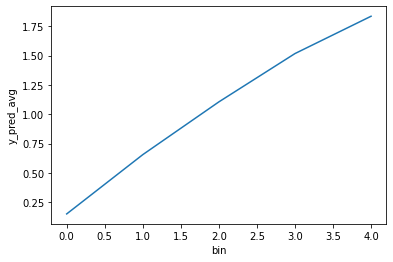

In [254]:
import seaborn as sns
sns.lineplot(data=df_vis_line, x="bin", y="y_pred_avg")

## Lisa Data

In [281]:
df_vis = pd.read_csv("data/compassion_energy/empathy_labelled_ds.csv")

In [283]:
df_vis['response_len'] = df_vis['response'].apply(lambda x: len(x.split(" ")))

In [284]:
df_vis['bin'] = pd.qcut(df_vis['response_len'], 5, labels=[0,1,2,3,4])

In [287]:
df_vis.head()

,response,annotator1_score,annotator2_score,annotator3_score,empathy_score,response_len,bin
0,When you've selected the protocol you want to ...,1,2,2,2,24,3
1,Did something happen to you?,0,0,1,0,5,0
2,"Thank you for taking part, I really appreciate...",2,1,2,2,19,2
3,I am grateful for your participation. I hope t...,1,2,2,2,14,1
4,"Thank you for being so open, I'm trying to det...",2,2,2,2,37,4


In [292]:
df_vis_line = df_vis[['bin', 'response_len', 'empathy_score']].groupby(['bin']).mean()

In [293]:
df_vis_line

,response_len,empathy_score
bin,,
0,9.660584,0.321168
1,14.021858,0.677596
2,17.322314,1.070248
3,22.495146,1.500000
4,32.989744,1.897436
